In [ ]:
! nvidia-smi

Tue Jun 22 05:41:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
! pip install keras-tuner

In [ ]:
import tensorflow
from tensorflow import keras
import keras_tuner as kt
import os
import numpy as np
# import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Masking, LSTM, Dropout, Permute, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, concatenate, multiply, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
num_classes = 20

### Some utility functions

In [ ]:
def load_X(path):
    X_signals = []
    files = os.listdir(path)
    files.sort(key=str.lower)
    #['train_acc_x.txt', 'train_acc_y.txt', 'train_acc_z.txt', 'train_gyr_x.txt', 'train_gyr_y.txt', 'train_gyr_z.txt']
    for my_file in files:
        fileName = os.path.join(path,my_file)
        file = open(fileName, 'r')
        X_signals.append(
            [np.array(cell, dtype=np.float32) for cell in [
                row.strip().split(' ') for row in file
            ]]
        )
        file.close()
        #X_signals = 6*totalStepNum*128
    X_signals = np.transpose(np.array(X_signals), (1, 0, 2))#(totalStepNum*6*128)
    return X_signals.reshape(-1,6,128,1)#(totalStepNum*6*128*1)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    y_ = y_ - 1
    #one_hot
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [ ]:
def plot_performance(X_train, train_label):
    history = model.fit(X_train, train_label, validation_split = 0.1, epochs=200, shuffle=True, batch_size=512, callbacks=keras.callbacks.EarlyStopping(monitor='val_loss', patience=50))#, callbacks=[es_callback])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
def get_test_performance(model, X_test, test_label):
    score = model.evaluate(X_test, test_label, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

### Squeeze Excite Block

In [ ]:
def squeeze_excite_block(tensor, ratio=16):
    init = tensor
    # channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[-1]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    # if K.image_data_format() == 'channels_first':
    #     se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Dataset 2

# Model without Tuning

In [ ]:
def MLSTM_FCN():
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.8)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(128, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(256, 5, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(128, 3, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(20, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
    model.summary()

    return model

model = MLSTM_FCN()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute_4 (Permute)             (None, 128, 6)       0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 128, 128)     6272        permute_4[0][0]                  
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 128, 128)     512         conv1d_12[0][0]                  
____________________________________________________________________________________________

In [ ]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')

In [ ]:
model = MLSTM_FCN((X_train.shape[1], X_train.shape[2]), train_label.shape[1])

Epoch 1/100
78/78 [==============================] - 48s 99ms/step - loss: 1.4832 - accuracy: 0.6207 - val_loss: 1.6609 - val_accuracy: 0.4777
Epoch 2/100
78/78 [==============================] - 6s 73ms/step - loss: 0.1725 - accuracy: 0.9665 - val_loss: 0.8986 - val_accuracy: 0.7709
Epoch 3/100
78/78 [==============================] - 6s 73ms/step - loss: 0.0790 - accuracy: 0.9838 - val_loss: 0.3074 - val_accuracy: 0.9447
Epoch 4/100
78/78 [==============================] - 6s 73ms/step - loss: 0.0510 - accuracy: 0.9893 - val_loss: 0.0782 - val_accuracy: 0.9869
Epoch 5/100
78/78 [==============================] - 6s 74ms/step - loss: 0.0385 - accuracy: 0.9912 - val_loss: 0.0919 - val_accuracy: 0.9743
Epoch 6/100
78/78 [==============================] - 6s 74ms/step - loss: 0.0306 - accuracy: 0.9924 - val_loss: 0.0423 - val_accuracy: 0.9885
Epoch 7/100
78/78 [==============================] - 6s 74ms/step - loss: 0.0292 - accuracy: 0.9929 - val_loss: 0.0362 - val_accuracy: 0.9901
Epoch

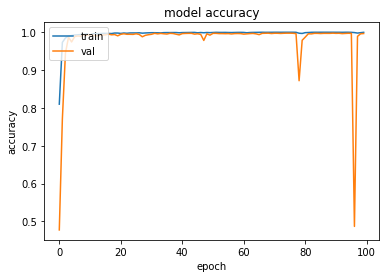

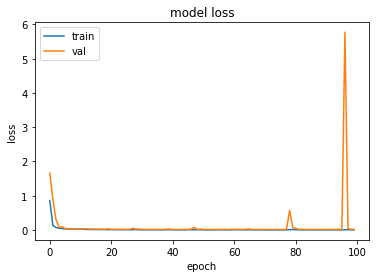

In [ ]:
plot_performance(X_train, train_label)

In [ ]:
get_test_performance(model, X_test, test_label)

Test loss: 0.22146883606910706
Test accuracy: 0.9736629128456116


> Accuracy achived: 97.37 (Previous best: 97.33)

# Model Tuned with keras Tuner

In [ ]:
def MLSTM_FCN_tuned_all(hp):
    ip = Input(shape=(6, 128))
    x = Masking()(ip)
    x = LSTM(units=hp.Int('lstm_1', min_value=8, max_value=128, step=16))(x)
    x = Dropout(hp.Choice(name='Dropout', values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]))(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(hp.Int('conv_1_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_1_filter_stride', values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_2_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_2_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(hp.Int('conv_3_filter', min_value=8, max_value=128, step=16), hp.Choice(name='conv_3_filter_stride',values = [3,5,7,8,9]), padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 3*1e-1, 3*1e-2, 3*1e-3, 3*1e-4, 1e-4, 1.0])), \
                  loss='categorical_crossentropy',metrics=['accuracy'])
    # model.summary()

    return model

# Dataset 2 with Tuned architecture

In [ ]:
X_train = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/Inertial Signals')
X_test = load_X('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/Inertial Signals')
train_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/train/y_train.txt')
test_label = load_y('/content/drive/Shareddrives/MMH/TIFS20/Dataset #2/test/y_test.txt')
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
tuner = kt.tuners.RandomSearch(
    MLSTM_FCN_tuned_all,
    objective='val_accuracy',
    max_trials=10,
    directory='output',
    project_name='MLSTM_FCN_dataset_2')

tuner.search(X_train, train_label, epochs=100, validation_split=0.1, shuffle=True, callbacks=[tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)])

Trial 3 Complete [00h 13m 45s]
val_accuracy: 0.9968425631523132

Best val_accuracy So Far: 0.9968425631523132
Total elapsed time: 00h 41m 35s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
lstm_1            |88                |88                
Dropout           |0.2               |0.3               
conv_1_filter     |120               |40                
conv_1_filter_s...|9                 |7                 
conv_2_filter     |8                 |88                
conv_2_filter_s...|5                 |8                 
conv_3_filter     |88                |120               
conv_3_filter_s...|5                 |8                 
learning_rate     |0.003             |0.03              

Epoch 1/100


In [ ]:
def MLSTM_FCN():
    x = Input(shape=(6, 128))
    ip = x
    x = Masking()(ip)
    x = LSTM(units=8)(x)
    x = Dropout(0.3)(x)
    y = Permute((2, 1))(ip)
    y = Conv1D(40, 7, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(88, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = squeeze_excite_block(y)
    y = Conv1D(120, 8, padding='same', kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = GlobalAveragePooling1D()(y)
    x = concatenate([x,y])
    
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(ip, out)
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(
    learning_rate=0.03), loss="categorical_crossentropy", metrics="accuracy")
    model.summary()

    return model

model = MLSTM_FCN()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 128)]     0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 128, 6)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 128, 40)      1720        permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 40)      160         conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
model.summary()

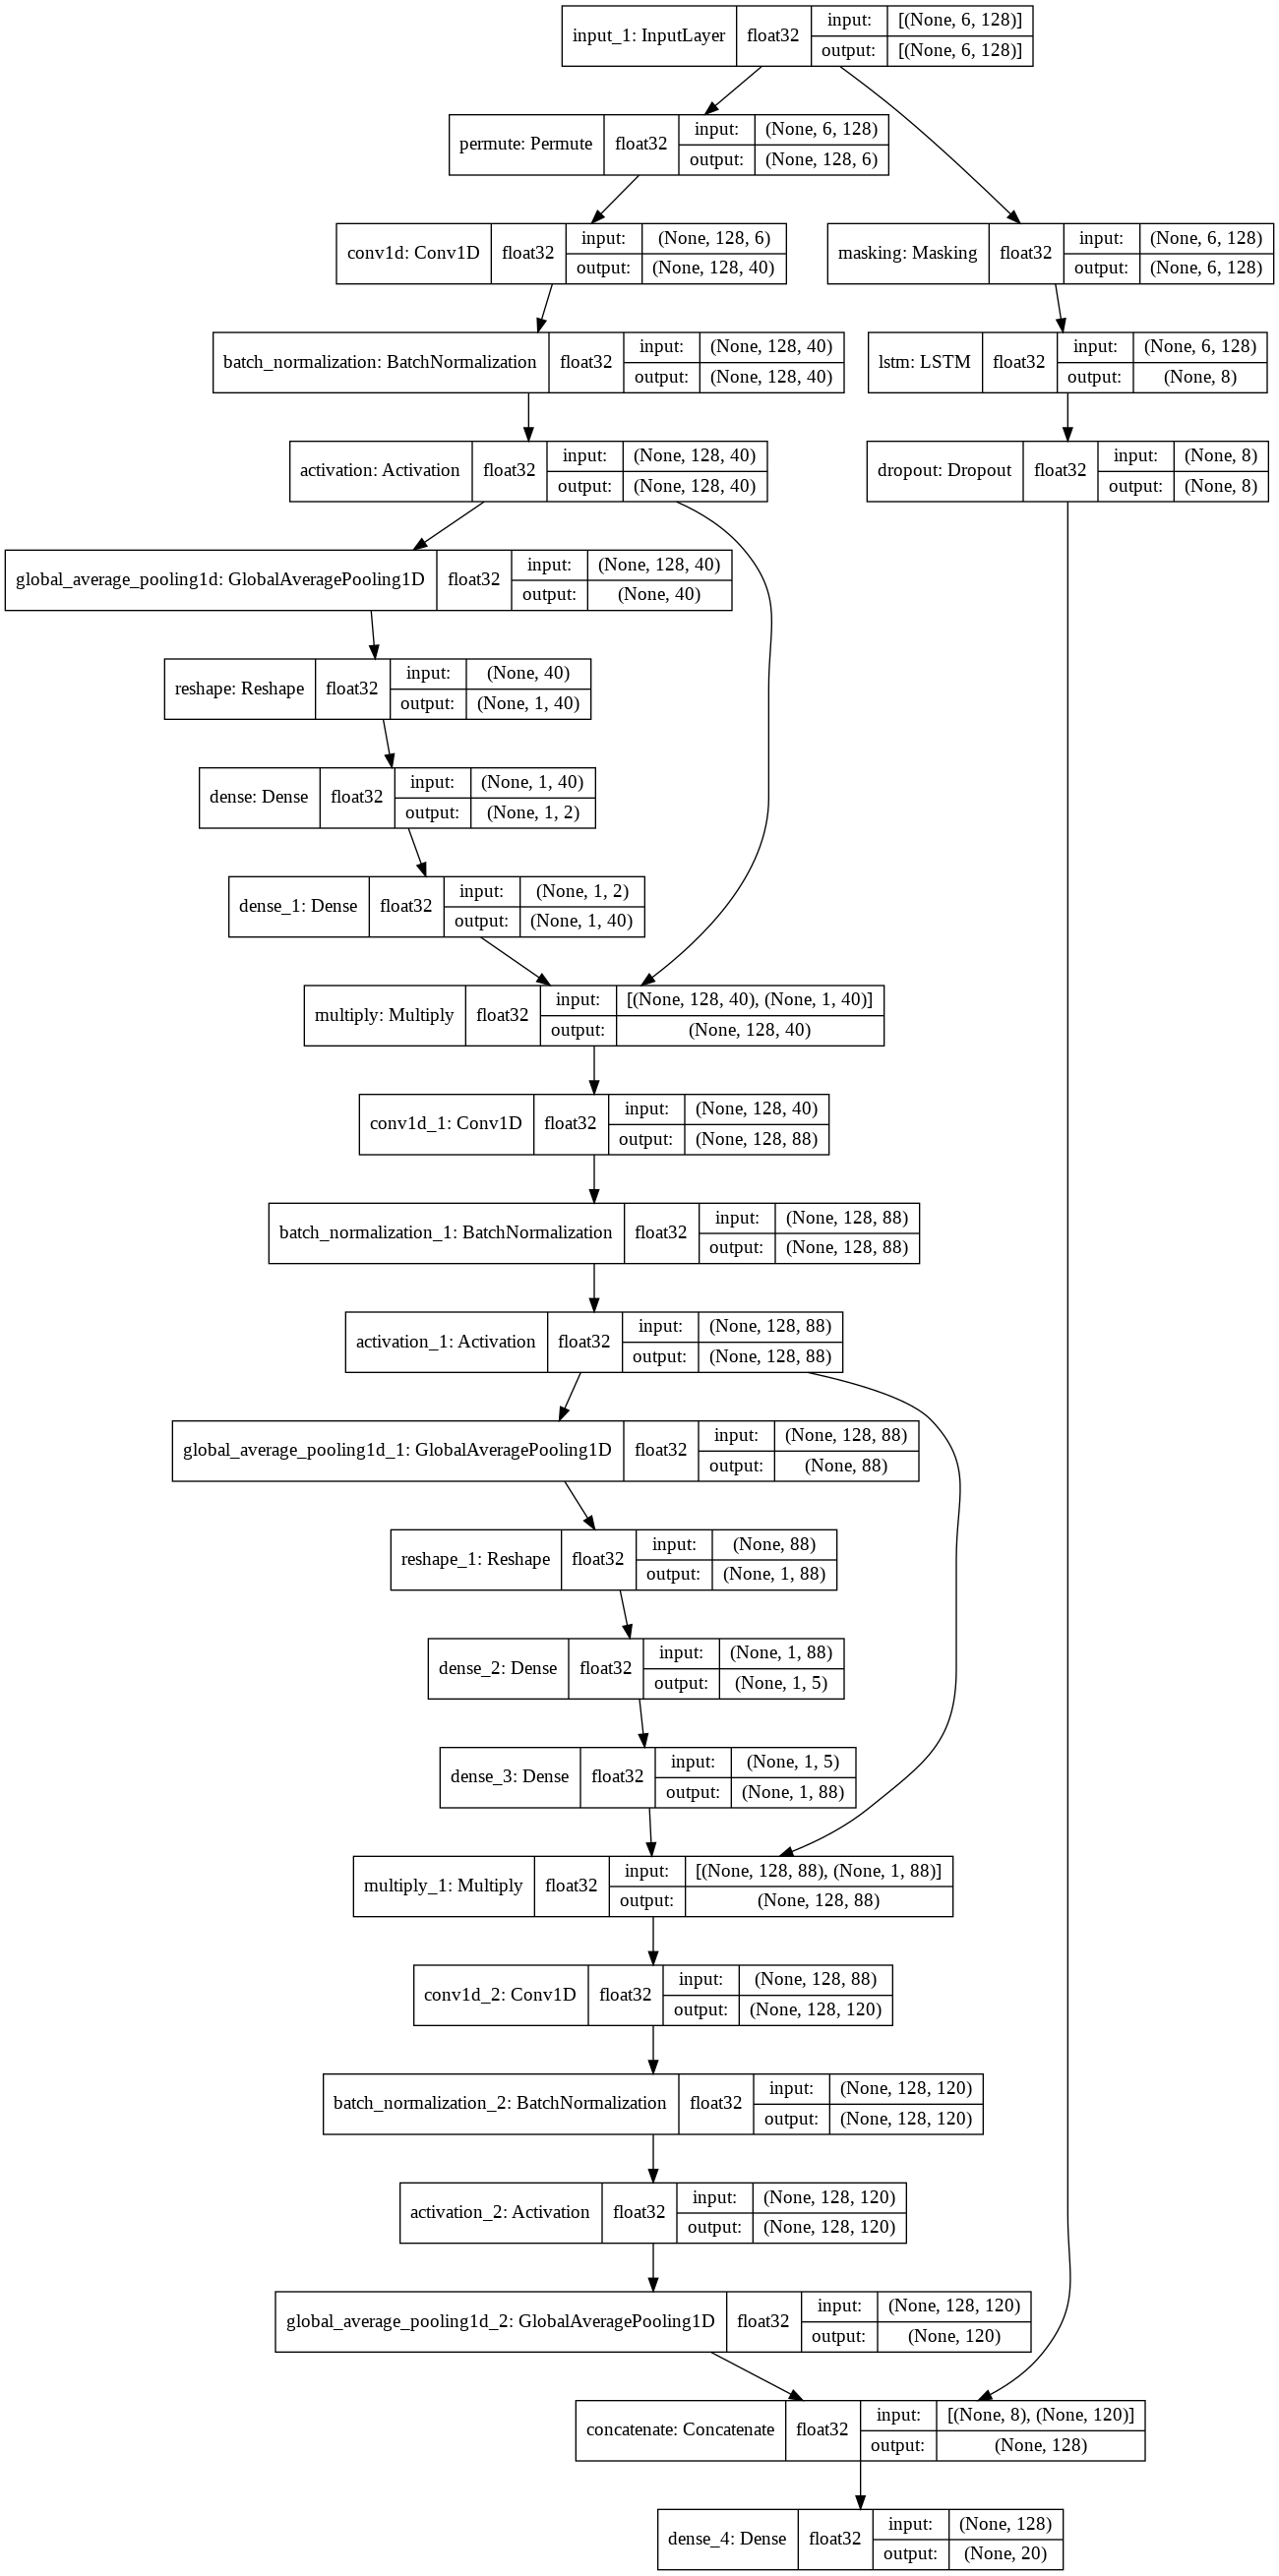

In [ ]:
tensorflow.keras.utils.plot_model(
    model, to_file='/content/drive/Shareddrives/MMH/models/images/MLSTM_FCN_tuned.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96
)

Epoch 1/200
78/78 [==============================] - 3s 42ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.2558 - val_accuracy: 0.9662
Epoch 2/200
78/78 [==============================] - 3s 41ms/step - loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0515 - val_accuracy: 0.9941
Epoch 3/200
78/78 [==============================] - 3s 41ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0335 - val_accuracy: 0.9935
Epoch 4/200
78/78 [==============================] - 3s 42ms/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.0277 - val_accuracy: 0.9946
Epoch 5/200
78/78 [==============================] - 3s 41ms/step - loss: 5.6769e-04 - accuracy: 0.9998 - val_loss: 0.0182 - val_accuracy: 0.9959
Epoch 6/200
78/78 [==============================] - 3s 41ms/step - loss: 5.8158e-04 - accuracy: 0.9998 - val_loss: 0.0233 - val_accuracy: 0.9966
Epoch 7/200
78/78 [==============================] - 3s 42ms/step - loss: 4.5033e-04 - accuracy: 0.9998 - val_loss: 0.0228 - val_accuracy: 0

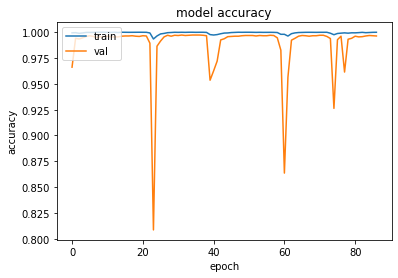

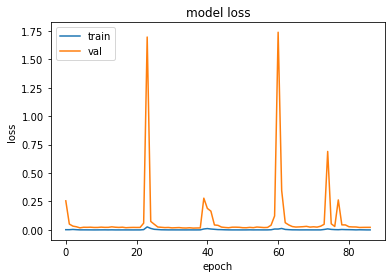

In [ ]:
plot_performance(X_train, train_label)

In [ ]:
get_test_performance(model, X_test, test_label)

Test loss: 0.5671589970588684
Test accuracy: 0.9764991998672485


In [ ]:
model.save('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_Dataset_2_acc_97_65.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model = tensorflow.keras.models.load_model('/content/drive/Shareddrives/MMH/models/MLSTM_FCN_Dataset_2_acc_97_65.h5')

In [ ]:
layers = ['lstm_1', 'Dropout', 'conv_1_filter', 'conv_1_filter_stride', 'conv_2_filter', 'conv_2_filter_stride', 'conv_3_filter', 'conv_3_filter_stride', 'learning_rate']

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print('Optimal Hyperparameters:')

for i in layers:
    print(f"{i}: {best_hyperparameters.get(i)}")

> Accuracy achived: 
 - Without Tuner: 97.37 (Previous best: 97.33) 
 - With Tuner: 97.65